<a href="https://colab.research.google.com/github/drscicomm/obesity_network/blob/main/Obesity_Feb2021_20210321.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#set up environment
!pip uninstall twint -y

Uninstalling twint-2.1.21:
  Successfully uninstalled twint-2.1.21


In [2]:
# Reinstall new version Twint
!pip3 install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint

  Cloning https://github.com/twintproject/twint.git (to revision origin/master) to /tmp/pip-install-bverm8ip/twint
  Running command git clone -q https://github.com/twintproject/twint.git /tmp/pip-install-bverm8ip/twint
  Running command git checkout -q origin/master
  Created wheel for twint: filename=twint-2.1.21-cp37-none-any.whl size=38863 sha256=467783dc49069c5a725cb7e93e258a55baa74059ce4eaec2ef982e4f8b97d578
  Stored in directory: /tmp/pip-ephem-wheel-cache-pql88yoh/wheels/4f/3b/75/62d04b3b446658ba85401e8868d3cd1d4bc22f17ad755460a6
Successfully built twint
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
# other environments needed
!pip3 install nest_asyncio
!pip3 install python-dotenv

In [4]:
!pip freeze > requirements.txt

In [5]:
# import packages
import os, sys, time, csv, math
# Basic utilities for processing data in python
import pandas as pd
import numpy as np
import twint
import nest_asyncio
nest_asyncio.apply()
from collections import Counter


In [6]:
# Twitter API client
import tweepy
from tweepy import Cursor

In [7]:
c = twint.Config()

c.Search = 'obesity'

c.Since = '2021-02-01'
c.Until = '2021-03-01'

c.Hide_output = True

c.Store_json = True
c.Output = 'obesity_Feb21.json'

In [8]:
# Run twint on configured qp

twint.run.Search(c)
print("Running search query")

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
Running search query


In [9]:
df = pd.read_json('obesity_Feb21.json', lines = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49783 entries, 0 to 49782
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   id               49783 non-null  int64              
 1   conversation_id  49783 non-null  int64              
 2   created_at       49783 non-null  datetime64[ns, UTC]
 3   date             49783 non-null  datetime64[ns]     
 4   time             49783 non-null  object             
 5   timezone         49783 non-null  int64              
 6   user_id          49783 non-null  int64              
 7   username         49783 non-null  object             
 8   name             49783 non-null  object             
 9   place            49783 non-null  object             
 10  tweet            49783 non-null  object             
 11  language         49783 non-null  object             
 12  mentions         49783 non-null  object             
 13  urls            

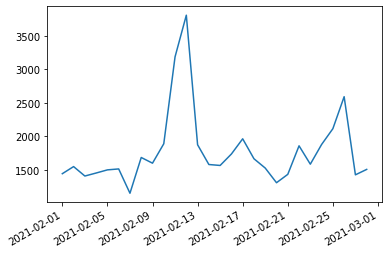

In [10]:
%matplotlib inline

df['date'].value_counts().plot()

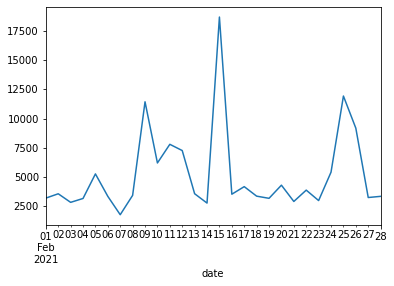

In [11]:
df['tweet_counts'] = df['retweets_count'] + 1

df.groupby(df["date"]).sum()["tweet_counts"].plot()

In [12]:
# save to csv file
df.to_csv('obesity_Mar20.csv')

In [13]:
# setting up packages for creating edges and nodes
import sys
import json
import re
import numpy as np
from datetime import datetime
import pandas as pd  

tweetfile = 'obesity_Mar20.csv'

tweets = pd.read_csv(tweetfile)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,8,9,10,11,12,13,14,15,19,20,21,22,23,25,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**1. Set up edges from retweets, replies, and mentions**

In [14]:
# creating edge file
# 1. Export edges from Retweets
retweets = tweets[tweets['retweet'] == 'True']
retweets['original_twitter'] = retweets['tweet'].str.extract('RT @([a-zA-Z0-9]\w{0,}):', expand=True)

edges = retweets[['username', 'original_twitter','created_at']]
edges.columns = ['Source', 'Target', 'Strength']

In [15]:
# 2. Export edges from Mentions

mentions = tweets[tweets['mentions'].notnull()]

edges = pd.DataFrame(columns=('Source','Target','Strength'))

for index, row in mentions.iterrows():
    mention_list = row['mentions'].split(", ")
    for mention in mention_list:
        edges = edges.append(pd.DataFrame([[row['username'],
                                        mention,
                                        row['created_at']]]
                                        , columns=('Source','Target','Strength')), ignore_index=True)

In [16]:
# 3. Export edges from Replies

replies = tweets[tweets['reply_to'].notnull()]

edges = replies[['username', 'reply_to','created_at']]
edges.columns = ['Source', 'Target', 'Strength']

**2. Leave only the tweets whose strength level >= user specified level (directed)**

In [17]:
strengthLevel = 1  # Network connection strength level: the number of times in total each of the tweeters responded to or mentioned the other.
                   # If you have 1 as the level, then all tweeters who mentioned or replied to another at least once will be displayed. But if you have 5, only those who have mentioned or responded to a particular tweeter at least 5 times will be displayed, which means that only the strongest bonds are shown.

edges2 = edges.groupby(['Source','Target'])['Strength'].count()
edges2 = edges2.reset_index()
edges2 = edges2[edges2['Strength'] >= strengthLevel]

**3. Export nodes**

In [20]:

users = tweets[['username']] # leaving out ,'followers_count','friends_count' because I can't figure out how to scape this data with the above query...
# leaving out line: users = users.sort_values(['username','followers_count'], ascending=[True, False])
users = users.drop_duplicates(['username'], keep='first') 

ids = edges2['Source'].append(edges2['Target']).to_frame()
ids['Label'] = ids
ids.columns = ['username', 'Label']
ids = ids.drop_duplicates(['username'], keep='first') 
nodes = pd.merge(ids, users, on='username', how='left')

In [21]:
print(nodes.shape)
print(edges2.shape)

(50737, 2)
(39104, 3)


In [22]:
# change column names for Kumu import (Run this when using Kumu)
edges2.columns = ['From','To','Strength']

In [23]:
# Print nodes to check
nodes.head(3)

,username,Label
0,001mellie,001mellie
1,007pete,007pete
2,00_pixie,00_pixie


In [24]:
# Print edges to check
edges2.head(3)

,From,To,Strength
0,001mellie,[],1
1,007pete,"[{'screen_name': 'Nate_D_Stone', 'name': 'Nate...",1
2,00_pixie,[],1


In [25]:
# Export nodes and edges to csv files
nodes.to_csv('Feb2021_nodes.csv', encoding='utf-8', index=False)
edges2.to_csv('Feb2021_edges.csv', encoding='utf-8', index=False)